In [1]:
import h5py
from tqdm.notebook import tqdm
import scipy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, DataLoader, RandomNodeLoader, DynamicBatchSampler
from torch_geometric.nn import (
    MessagePassing, GCNConv, PPFConv, MetaLayer, EdgeConv,
    global_mean_pool, global_max_pool, global_add_pool
)
from torch_geometric.transforms import IndexToMask
from torch_cluster import radius_graph

import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import illustris_python as il

from tqdm import tqdm
from easyquery import Query


ROOT = Path("..").resolve().parent
tng_base_path = f"{ROOT}/illustris_data/TNG300-1/output"

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'


import cmasher as cmr
C0, C1, C2, C3 = cmr.take_cmap_colors('cmr.rainforest', 4, cmap_range=(0.8, 0.2), return_fmt='hex')




## Get subhalos from hydro run

In [2]:
cuts = {
    "minimum_log_stellar_mass": 9,
    "minimum_log_halo_mass": 10,
    "minimum_n_star_particles": 10
}

config_params = dict(
    boxsize=(205e3 / 0.6774),    # box size in comoving kpc/h
    h_reduced=0.6774,   # reduced Hubble constant
    snapshot=99,       # z = 0
)

normalization_params = dict(
    norm_half_mass_radius=8., 
    norm_velocity=100.
)

In [3]:
def load_subhalos(hydro=True, config_params=config_params, normalization_params=normalization_params, cuts=cuts, snapshot=99):
    
    use_cols = ['subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_loghalomass', 'subhalo_logvmax'] 
    y_cols = ['subhalo_logstellarmass']

 
    base_path = tng_base_path.replace("TNG300-1", "TNG300-1-Dark") if not hydro else tng_base_path

    subhalo_fields = [
        "SubhaloPos", "SubhaloMassType", "SubhaloLenType", "SubhaloHalfmassRadType", 
        "SubhaloVel", "SubhaloVmax", "SubhaloGrNr", 
    ]

    if hydro:
        subhalo_fields += ["SubhaloFlag"]

    subhalos = il.groupcat.loadSubhalos(base_path, snapshot, fields=subhalo_fields) 

    h = config_params["h_reduced"]
    pos = subhalos["SubhaloPos"][:,:3]
    min_box, max_box = np.rint(np.min(pos)), np.rint(np.max(pos))
    box_size = max_box/(h*1e3) # in Mpc

    halo_fields = ["Group_M_Crit200", "GroupFirstSub", "GroupPos", "GroupVel"]
    halos = il.groupcat.loadHalos(base_path, snapshot, fields=halo_fields)

    subhalo_pos = subhalos["SubhaloPos"][:] / (h*1e3)
    subhalo_stellarmass = subhalos["SubhaloMassType"][:,4]
    subhalo_halomass = subhalos["SubhaloMassType"][:,1]
    subhalo_n_stellar_particles = subhalos["SubhaloLenType"][:,4]
    subhalo_stellarhalfmassradius = subhalos["SubhaloHalfmassRadType"][:,4]  / normalization_params["norm_half_mass_radius"]
    subhalo_vel = subhalos["SubhaloVel"][:] /  normalization_params["norm_velocity"]
    subhalo_vmax = subhalos["SubhaloVmax"][:] / normalization_params["norm_velocity"]
    subhalo_flag = subhalos["SubhaloFlag"][:] if hydro else np.ones_like(subhalo_halomass) # note dummy values of 1 if DMO
    halo_id = subhalos["SubhaloGrNr"][:].astype(int)

    halo_mass = halos["Group_M_Crit200"][:]
    halo_primarysubhalo = halos["GroupFirstSub"][:].astype(int)
    group_pos = halos["GroupPos"][:] / (h*1e3)
    group_vel = halos["GroupVel"][:]  / normalization_params["norm_velocity"]

    halos = pd.DataFrame(
        np.column_stack((np.arange(len(halo_mass)), group_pos, group_vel, halo_mass, halo_primarysubhalo)),
        columns=['halo_id', 'halo_x', 'halo_y', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_mass', 'halo_primarysubhalo']
    )
    halos['halo_id'] = halos['halo_id'].astype(int)
    halos.set_index("halo_id", inplace=True)
    
    # get subhalos/galaxies      
    subhalos = pd.DataFrame(
        np.column_stack([halo_id, subhalo_flag, np.arange(len(subhalo_stellarmass)), subhalo_pos, subhalo_vel, subhalo_n_stellar_particles, subhalo_stellarmass, subhalo_halomass, subhalo_stellarhalfmassradius, subhalo_vmax]), 
        columns=['halo_id', 'subhalo_flag', 'subhalo_id', 'subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy', 'subhalo_vz', 'subhalo_n_stellar_particles', 'subhalo_stellarmass', 'subhalo_halomass', 'subhalo_stellarhalfmassradius', 'subhalo_vmax'],
    )
    subhalos["is_central"] = (halos.loc[subhalos.halo_id]["halo_primarysubhalo"].values == subhalos["subhalo_id"].values)
    
    # DMO-hydro matching
    if hydro:
        dmo_hydro_match = h5py.File(f"{ROOT}/illustris_data/TNG300-1/postprocessing/subhalo_matching_to_dark.hdf5")
        subhalos["subhalo_l_halo_tree"] = dmo_hydro_match["Snapshot_99"]["SubhaloIndexDark_LHaloTree"]
        subhalos["subhalo_sublink"] = dmo_hydro_match["Snapshot_99"]["SubhaloIndexDark_SubLink"]      

    # only drop in hydro
    if hydro:
        subhalos = subhalos[subhalos["subhalo_flag"] != 0].copy()
    subhalos['halo_id'] = subhalos['halo_id'].astype(int)
    subhalos['subhalo_id'] = subhalos['subhalo_id'].astype(int)

    subhalos["subhalo_logstellarmass"] = np.log10(subhalos["subhalo_stellarmass"] / h)+10
    subhalos["subhalo_loghalomass"] = np.log10(subhalos["subhalo_halomass"] / h)+10
    subhalos["subhalo_logvmax"] = np.log10(subhalos["subhalo_vmax"])
    subhalos["subhalo_logstellarhalfmassradius"] = np.log10(subhalos["subhalo_stellarhalfmassradius"])
    
    
    if hydro:
        # DM cuts
        subhalos.drop("subhalo_flag", axis=1, inplace=True)
        subhalos = subhalos[subhalos["subhalo_loghalomass"] > cuts["minimum_log_halo_mass"]].copy()
        # stellar mass and particle cuts
        subhalos = subhalos[subhalos["subhalo_n_stellar_particles"] > cuts["minimum_n_star_particles"]].copy()
        subhalos = subhalos[subhalos["subhalo_logstellarmass"] > cuts["minimum_log_stellar_mass"]].copy()
    
    
    return subhalos

In [4]:
subhalos = load_subhalos()
subhalos.shape

/home/john/miniconda3/envs/pyg/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/john/miniconda3/envs/pyg/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/john/miniconda3/envs/pyg/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(268737, 20)

In [5]:
subhalos.sample(5, random_state=42)

,halo_id,subhalo_id,subhalo_x,subhalo_y,subhalo_z,subhalo_vx,subhalo_vy,subhalo_vz,subhalo_n_stellar_particles,subhalo_stellarmass,subhalo_halomass,subhalo_stellarhalfmassradius,subhalo_vmax,is_central,subhalo_l_halo_tree,subhalo_sublink,subhalo_logstellarmass,subhalo_loghalomass,subhalo_logvmax,subhalo_logstellarhalfmassradius
1887294,40911,1887294,44.251587,237.768204,295.559662,-0.321845,-2.455722,1.514715,3502.0,1.862686,68.379517,0.788538,1.874227,True,2344943,2344943,10.439295,12.004081,0.272822,-0.103177
697490,1006,697490,273.632568,121.477036,297.191193,-2.798098,6.001591,-1.652563,1537.0,0.826827,8.122209,0.373596,1.384066,False,-1,880136,10.086570,11.078829,0.141157,-0.427598
1952776,49549,1952776,9.932620,8.577056,225.829224,3.033714,-2.632222,-3.030788,207.0,0.117202,1.334448,0.238872,1.042266,False,-1,2491551,9.238091,10.294457,0.017979,-0.621834
826720,1562,826720,100.012604,53.868114,84.768394,-0.234195,-0.973612,-2.406914,454.0,0.242021,0.693116,0.281424,0.851381,False,-1,1052188,9.553008,10.009961,-0.069876,-0.550639
2418175,165334,2418175,53.806656,129.003952,238.060638,3.206215,-4.703946,-5.348281,162.0,0.091333,13.523736,0.674110,0.904255,True,2911885,2911885,9.129785,11.300251,-0.043709,-0.171269


## Load and compare DMO subhalos

In [6]:
subhalos_dmo = load_subhalos(hydro=False)
subhalos_dmo.shape

/home/john/miniconda3/envs/pyg/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/john/miniconda3/envs/pyg/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(15724587, 19)

In [7]:
subhalos_dmo.sample(5, random_state=42)

,halo_id,subhalo_flag,subhalo_id,subhalo_x,subhalo_y,subhalo_z,subhalo_vx,subhalo_vy,subhalo_vz,subhalo_n_stellar_particles,subhalo_stellarmass,subhalo_halomass,subhalo_stellarhalfmassradius,subhalo_vmax,is_central,subhalo_logstellarmass,subhalo_loghalomass,subhalo_logvmax,subhalo_logstellarhalfmassradius
544655,321,1.0,544655,268.605774,273.090179,244.756485,-3.082764,12.674692,-5.023078,0.0,0.0,0.293084,0.0,0.300842,False,-inf,9.636147,-0.521662,-inf
15344317,12529377,1.0,15344317,253.907883,180.351608,6.520134,4.073870,-5.149409,-3.038159,0.0,0.0,0.113452,0.0,0.215134,True,-inf,9.223967,-0.667291,-inf
13608443,10404461,1.0,13608443,13.734420,27.413385,97.485306,-0.931827,-1.748086,-0.924994,0.0,0.0,0.151269,0.0,0.187588,True,-inf,9.348905,-0.726795,-inf
2594898,65288,1.0,2594898,187.768280,275.316254,256.060028,-0.626214,-1.090717,0.032041,0.0,0.0,0.609804,0.0,0.435914,False,-inf,9.954345,-0.360600,-inf
12837035,9498426,1.0,12837035,37.509758,299.351105,299.017639,-0.229592,4.227746,0.351815,0.0,0.0,0.151269,0.0,0.255050,True,-inf,9.348905,-0.593374,-inf


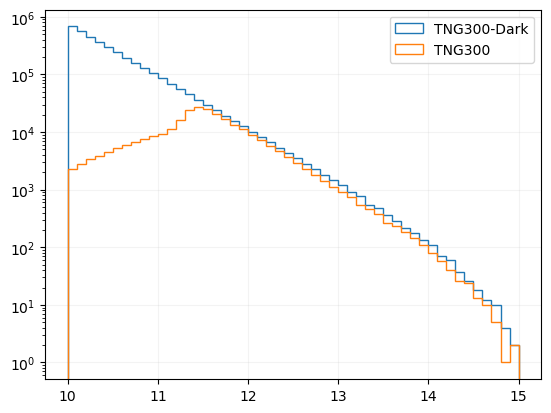

In [8]:
plt.hist(subhalos_dmo.subhalo_loghalomass, range=[10, 15], bins=50, log=True, density=False, histtype="step", label="TNG300-Dark");
plt.hist(subhalos.subhalo_loghalomass, range=[10, 15], bins=50, log=True, density=False, histtype="step", label="TNG300");

plt.legend()
plt.grid(alpha=0.15)

## Match DMO and hydro

In [9]:
# where subhalo_l_halo_tree is valid
valid_idxs_l_halo_tree = subhalos_dmo.index.isin(subhalos.subhalo_l_halo_tree)
valid_idxs_l_halo_tree.sum()

231043

In [10]:
valid_idxs_sublink = subhalos_dmo.index.isin(subhalos.subhalo_sublink)
valid_idxs_sublink.sum()

251447

In [11]:
subhalos_dmo_l_halo_tree = pd.concat(
    [
        (
            subhalos_dmo
            .loc[subhalos.subhalo_l_halo_tree[subhalos.subhalo_l_halo_tree != -1]]
            .reset_index(drop=True)
            .rename({c: c+"_DMO" for c in subhalos_dmo.columns}, axis=1)
        ),
        subhalos[subhalos.subhalo_l_halo_tree != -1].reset_index(drop=True),
    ], 
    axis=1,
)


In [12]:
subhalos_dmo_l_halo_tree.columns

Index(['halo_id_DMO', 'subhalo_flag_DMO', 'subhalo_id_DMO', 'subhalo_x_DMO',
       'subhalo_y_DMO', 'subhalo_z_DMO', 'subhalo_vx_DMO', 'subhalo_vy_DMO',
       'subhalo_vz_DMO', 'subhalo_n_stellar_particles_DMO',
       'subhalo_stellarmass_DMO', 'subhalo_halomass_DMO',
       'subhalo_stellarhalfmassradius_DMO', 'subhalo_vmax_DMO',
       'is_central_DMO', 'subhalo_logstellarmass_DMO',
       'subhalo_loghalomass_DMO', 'subhalo_logvmax_DMO',
       'subhalo_logstellarhalfmassradius_DMO', 'halo_id', 'subhalo_id',
       'subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy',
       'subhalo_vz', 'subhalo_n_stellar_particles', 'subhalo_stellarmass',
       'subhalo_halomass', 'subhalo_stellarhalfmassradius', 'subhalo_vmax',
       'is_central', 'subhalo_l_halo_tree', 'subhalo_sublink',
       'subhalo_logstellarmass', 'subhalo_loghalomass', 'subhalo_logvmax',
       'subhalo_logstellarhalfmassradius'],
      dtype='object')

In [13]:
subhalos_dmo_l_halo_tree.to_parquet(f"{ROOT}/illustris_data/TNG300-1/subhalos_DMO-matched_LHaloTree.parquet")

In [14]:
subhalos_dmo_sublink = pd.concat(
    [
        (
            subhalos_dmo
            .loc[subhalos.subhalo_sublink[subhalos.subhalo_sublink != -1]]
            .reset_index(drop=True)
            .rename({c: c+"_DMO" for c in subhalos_dmo.columns}, axis=1)
        ),
        subhalos[subhalos.subhalo_sublink != -1].reset_index(drop=True),
    ], 
    axis=1,
)


In [15]:
subhalos_dmo_sublink.to_parquet(f"{ROOT}/illustris_data/TNG300-1/subhalos_DMO-matched_Sublink.parquet")

## Join hydro subhalos with cosmic web params

In [7]:


subhalos_dmo_sublink = pd.read_parquet(f"{ROOT}/illustris_data/TNG300-1/subhalos_DMO-matched_Sublink.parquet")
subhalos_dmo_l_halo_tree = pd.read_parquet(f"{ROOT}/illustris_data/TNG300-1/subhalos_DMO-matched_LHaloTree.parquet")

In [8]:
subhalos_dmo_sublink.shape, subhalos_dmo_l_halo_tree.shape

((268736, 39), (231043, 39))

In [9]:
subhalos_dmo_l_halo_tree

,halo_id_DMO,subhalo_flag_DMO,subhalo_id_DMO,subhalo_x_DMO,subhalo_y_DMO,subhalo_z_DMO,subhalo_vx_DMO,subhalo_vy_DMO,subhalo_vz_DMO,subhalo_n_stellar_particles_DMO,...,subhalo_halomass,subhalo_stellarhalfmassradius,subhalo_vmax,is_central,subhalo_l_halo_tree,subhalo_sublink,subhalo_logstellarmass,subhalo_loghalomass,subhalo_logvmax,subhalo_logstellarhalfmassradius
0,0,1.0,0,64.551239,72.062263,217.921570,4.510719,4.274035,-2.460215,0.0,...,108609.117188,16.258152,17.441303,True,0,0,12.894207,15.205021,1.241579,1.211071
1,0,1.0,1,67.068443,76.572205,216.105850,-2.395708,-7.636514,4.089011,0.0,...,31006.744141,14.791595,13.145017,False,1,1,12.573412,14.660611,1.118761,1.170015
2,0,1.0,5,65.566208,72.354858,218.523621,23.901012,15.384449,-15.651955,0.0,...,838.603088,1.658711,5.166094,False,5,5,11.927807,13.092711,0.713162,0.219771
3,0,1.0,8,64.758484,74.901749,218.061768,9.666151,-5.511534,-3.121190,0.0,...,470.912842,1.759728,3.819818,False,8,8,11.547731,12.842095,0.582043,0.245446
4,0,1.0,7,65.360092,73.399857,218.654999,-2.425336,-21.167299,-6.019178,0.0,...,445.307373,1.393500,4.003810,False,7,7,11.512752,12.817815,0.602474,0.144107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231038,1450260,1.0,5026326,221.114502,194.299698,86.781891,0.389018,-2.687401,-3.404191,0.0,...,1.143244,0.411924,0.800013,True,5026326,5026326,9.245514,10.227294,-0.096903,-0.385182
231039,2264675,1.0,5946150,285.400787,210.626266,267.155579,2.519367,-1.419733,0.432219,0.0,...,1.111376,0.578791,0.687372,True,5946150,5946150,9.264283,10.215016,-0.162808,-0.237479
231040,952,1.0,869469,272.285980,43.813061,77.387299,3.333777,3.427814,-2.493718,0.0,...,0.987890,0.719312,0.743172,True,869469,869469,9.032173,10.163863,-0.128911,-0.143083
231041,764409,1.0,4154962,66.117599,293.853180,34.399864,3.681364,-0.274971,3.095654,0.0,...,1.063575,0.571490,0.746717,True,4154962,4154962,9.142996,10.195923,-0.126844,-0.242991


In [10]:
# join with cosmic web
cw = h5py.File(f"{ROOT}/illustris_data/TNG300-1/postprocessing/disperse/disperse_099.hdf5")
cw = pd.DataFrame(
    {k: cw[k] for k in cw.keys()}
).rename({"subhalo_ID": "subhalo_id"}, axis=1).set_index("subhalo_id")


cw_normalization = dict(mean=cw.mean(0), std=cw.std(0))
cw = (cw - cw_normalization["mean"]) / cw_normalization["std"]

In [11]:
subhalos_dmo_sublink = subhalos_dmo_sublink.join(cw, on="subhalo_id", how="left")

In [12]:
subhalos_dmo_sublink.sample(5, random_state=42)

,halo_id_DMO,subhalo_flag_DMO,subhalo_id_DMO,subhalo_x_DMO,subhalo_y_DMO,subhalo_z_DMO,subhalo_vx_DMO,subhalo_vy_DMO,subhalo_vz_DMO,subhalo_n_stellar_particles_DMO,...,subhalo_sublink,subhalo_logstellarmass,subhalo_loghalomass,subhalo_logvmax,subhalo_logstellarhalfmassradius,d_minima,d_node,d_saddle_1,d_saddle_2,d_skel
20489,195,1.0,425089,295.940247,157.058182,38.258942,6.074587,-4.098048,-9.703228,0.0,...,425089,11.115483,12.310954,0.418190,0.056630,1.839271,-1.282896,1.511419,-0.659249,-1.007930
173111,68009,1.0,2613069,284.811279,104.898392,56.513447,0.932935,-0.075324,-0.966608,0.0,...,2613069,9.851305,11.752180,0.166729,-0.339628,1.343280,0.528368,2.015553,0.476535,0.778311
238363,152296,1.0,2999058,292.160400,212.215683,117.246201,1.177991,1.807928,3.907792,0.0,...,2999058,9.505680,11.392558,0.078374,-0.328844,1.632818,-0.759239,-0.775728,-0.343915,-0.294447
66946,3268,1.0,1330498,86.071854,122.457344,186.902023,-3.295067,0.271507,4.166556,0.0,...,1330498,11.299794,13.022825,0.525612,0.062937,-0.475923,-1.512387,-0.600473,-0.715144,-1.188581
249316,154206,1.0,3005482,271.875580,65.645164,47.282063,-1.250757,0.773638,2.086317,0.0,...,3005482,9.129642,11.374932,0.014755,-0.437955,1.361510,3.371405,3.105292,3.443519,3.999284


# Restrict to high-mass ($M_{\rm halo, DMO} > 10^{11}\ M_\odot$) objects

In [13]:
subhalos = subhalos_dmo_l_halo_tree[subhalos_dmo_l_halo_tree.subhalo_loghalomass_DMO > 11].copy()
subhalos.shape

(213957, 39)

In [14]:
subhalos.columns

Index(['halo_id_DMO', 'subhalo_flag_DMO', 'subhalo_id_DMO', 'subhalo_x_DMO',
       'subhalo_y_DMO', 'subhalo_z_DMO', 'subhalo_vx_DMO', 'subhalo_vy_DMO',
       'subhalo_vz_DMO', 'subhalo_n_stellar_particles_DMO',
       'subhalo_stellarmass_DMO', 'subhalo_halomass_DMO',
       'subhalo_stellarhalfmassradius_DMO', 'subhalo_vmax_DMO',
       'is_central_DMO', 'subhalo_logstellarmass_DMO',
       'subhalo_loghalomass_DMO', 'subhalo_logvmax_DMO',
       'subhalo_logstellarhalfmassradius_DMO', 'halo_id', 'subhalo_id',
       'subhalo_x', 'subhalo_y', 'subhalo_z', 'subhalo_vx', 'subhalo_vy',
       'subhalo_vz', 'subhalo_n_stellar_particles', 'subhalo_stellarmass',
       'subhalo_halomass', 'subhalo_stellarhalfmassradius', 'subhalo_vmax',
       'is_central', 'subhalo_l_halo_tree', 'subhalo_sublink',
       'subhalo_logstellarmass', 'subhalo_loghalomass', 'subhalo_logvmax',
       'subhalo_logstellarhalfmassradius'],
      dtype='object')

In [15]:
# force sublink and lhalotree to match
subhalos = subhalos[subhalos.subhalo_l_halo_tree == subhalos.subhalo_sublink].copy()
subhalos.shape

(213011, 39)

Text(0.5, 1.0, 'Hydro')

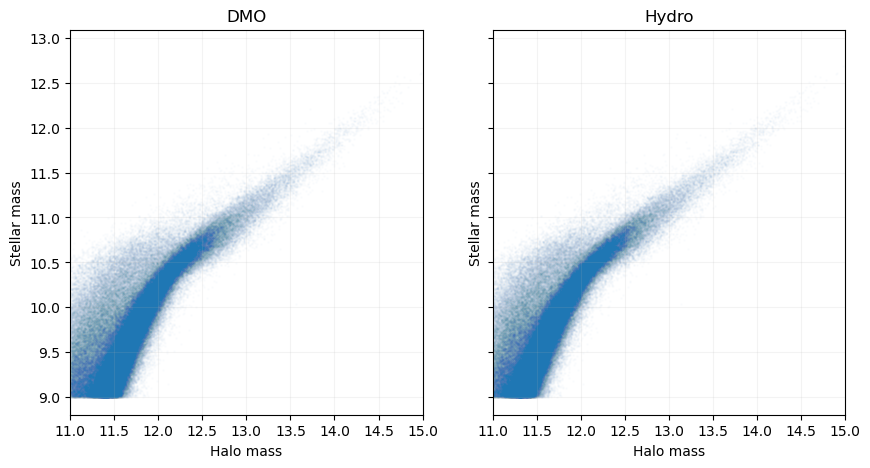

In [16]:
fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(10, 5), sharey=True)
ax1.scatter(subhalos.subhalo_loghalomass_DMO, subhalos.subhalo_logstellarmass, s=1, alpha=0.01)
ax2.scatter(subhalos.subhalo_loghalomass, subhalos.subhalo_logstellarmass, s=1, alpha=0.01)
for ax in [ax1, ax2]:
    ax.set_xlim(11, 15)
    ax.set_xlabel("Halo mass")
    ax.set_ylabel("Stellar mass")
    ax.grid(alpha=0.15)

ax1.set_title("DMO")
ax2.set_title("Hydro")

In [17]:
subhalos.is_central_DMO.mean()

0.7467079164925755

## Construct giant graph

In [18]:
box_size = 302.6277
split = 1
pad = 0
D_link = 2.5
periodic = True
use_loops = True

In [22]:
df = subhalos.copy()
df.reset_index(drop=True)

# DMO only properties
x = torch.tensor(df[['subhalo_loghalomass_DMO', 'subhalo_logvmax_DMO']].values, dtype=torch.float)

# hydro properties
x_hydro = torch.tensor(df[["subhalo_loghalomass", 'subhalo_logvmax']].values, dtype=torch.float)

# hydro total stellar mass
y = torch.tensor(df[['subhalo_logstellarmass']].values, dtype=torch.float)

# phase space coordinates
pos = torch.tensor(df[['subhalo_x_DMO', 'subhalo_y_DMO', 'subhalo_z_DMO']].values, dtype=torch.float)
vel = torch.tensor(df[['subhalo_vx_DMO', 'subhalo_vy_DMO', 'subhalo_vz_DMO']].values, dtype=torch.float)

pos_hydro = torch.tensor(df[['subhalo_x', 'subhalo_y', 'subhalo_z']].values, dtype=torch.float)
vel_hydro = torch.tensor(df[['subhalo_vx', 'subhalo_vy', 'subhalo_vz']].values, dtype=torch.float)

is_central = torch.tensor(df[['is_central']].values, dtype=torch.int)
halfmassradius = torch.tensor(df[['subhalo_logstellarhalfmassradius']].values, dtype=torch.float)

# this can take an absurdly long time
# overdensity on D_link scales
# overdensity = torch.zeros(len(x), dtype=x.dtype)
# for i in tqdm(range(len(x))): 
#     neighbors = edge_index[1, edge_index[0] == i] # get neighbor indices
#     overdensity[i] = torch.log10((10**x[neighbors, 0]).sum()) # get sum of masses of neighbors (0th index in `x`)

In [23]:


kd_tree = scipy.spatial.KDTree(pos, leafsize=25, boxsize=box_size)
edge_index = kd_tree.query_pairs(r=D_link, output_type="ndarray")

# normalize positions
df[['subhalo_x', 'subhalo_y', 'subhalo_z']] = df[['subhalo_x', 'subhalo_y', 'subhalo_z']]/(box_size/2)

# Add reverse pairs
reversepairs = np.zeros((edge_index.shape[0], 2))
for i, pair in enumerate(edge_index):
    reversepairs[i] = np.array([pair[1], pair[0]])
edge_index = np.append(edge_index, reversepairs, 0)

edge_index = edge_index.astype(int)

# Write in pytorch-geometric format
edge_index = edge_index.reshape((2,-1))
num_pairs = edge_index.shape[1]

row, col = edge_index

diff = pos[row]-pos[col]
dist = np.linalg.norm(diff, axis=1)

use_gal = True

if periodic:
    # Take into account periodic boundary conditions, correcting the distances
    for i, pos_i in enumerate(diff):
        for j, coord in enumerate(pos_i):
            if coord > D_link:
                diff[i,j] -= box_size  # Boxsize normalize to 1
            elif -coord > D_link:
                diff[i,j] += box_size  # Boxsize normalize to 1

centroid = np.array(pos.mean(0)) # define arbitrary coordinate, invarinat to translation/rotation shifts, but not stretches
# centroid+=1.2

unitrow = (pos[row]-centroid)/np.linalg.norm((pos[row]-centroid), axis=1).reshape(-1,1)
unitcol = (pos[col]-centroid)/np.linalg.norm((pos[col]-centroid), axis=1).reshape(-1,1)
unitdiff = diff/dist.reshape(-1,1)
# Dot products between unit vectors
cos1 = np.array([np.dot(unitrow[i,:].T,unitcol[i,:]) for i in range(num_pairs)])
cos2 = np.array([np.dot(unitrow[i,:].T,unitdiff[i,:]) for i in range(num_pairs)])

# same invariant edge features but for velocity
vel = np.vstack(df[['subhalo_vx', 'subhalo_vy', 'subhalo_vz']].to_numpy())
vel_diff = vel[row]-vel[col]
vel_norm = np.linalg.norm(vel_diff, axis=1)
vel_centroid = np.array(vel.mean(0))

vel_unitrow = (vel[row]-vel_centroid)/np.linalg.norm(vel[row]-vel_centroid, axis=1).reshape(-1, 1)
vel_unitcol = (vel[col]-vel_centroid)/np.linalg.norm(vel[col]-vel_centroid, axis=1).reshape(-1, 1)
vel_unitdiff = vel_diff / vel_norm.reshape(-1,1)
vel_cos1 = np.array([np.dot(vel_unitrow[i,:].T,vel_unitcol[i,:]) for i in range(num_pairs)])
vel_cos2 = np.array([np.dot(vel_unitrow[i,:].T,vel_unitdiff[i,:]) for i in range(num_pairs)])

# build edge features
edge_attr = np.concatenate([dist.reshape(-1,1), cos1.reshape(-1,1), cos2.reshape(-1,1), vel_norm.reshape(-1,1), vel_cos1.reshape(-1,1), vel_cos2.reshape(-1,1)], axis=1)

if use_loops:
    loops = np.zeros((2,pos.shape[0]),dtype=int)
    atrloops = np.zeros((pos.shape[0], edge_attr.shape[1]))
    for i, posit in enumerate(pos):
        loops[0,i], loops[1,i] = i, i
        atrloops[i,0], atrloops[i,1], atrloops[i,2] = 0., 1., 0.
    edge_index = np.append(edge_index, loops, 1)
    edge_attr = np.append(edge_attr, atrloops, 0)
edge_index = edge_index.astype(int)


/tmp/ipykernel_204148/1774088101.py:42: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  cos1 = np.array([np.dot(unitrow[i,:].T,unitcol[i,:]) for i in range(num_pairs)])


KeyboardInterrupt: 

## Node only graph

In [151]:
data_minimal = Data(
    x=x,
    y=y,
    positions=positions,
    velocities=velocities,
    is_central=is_central
)

In [154]:
loader = NeighborLoader(
    data_minimal,
    num_neighbors=[30] * 2,
    batch_size=256,
    # edge_label_index=data.edge_index,
)

In [155]:
b = next(iter(loader))

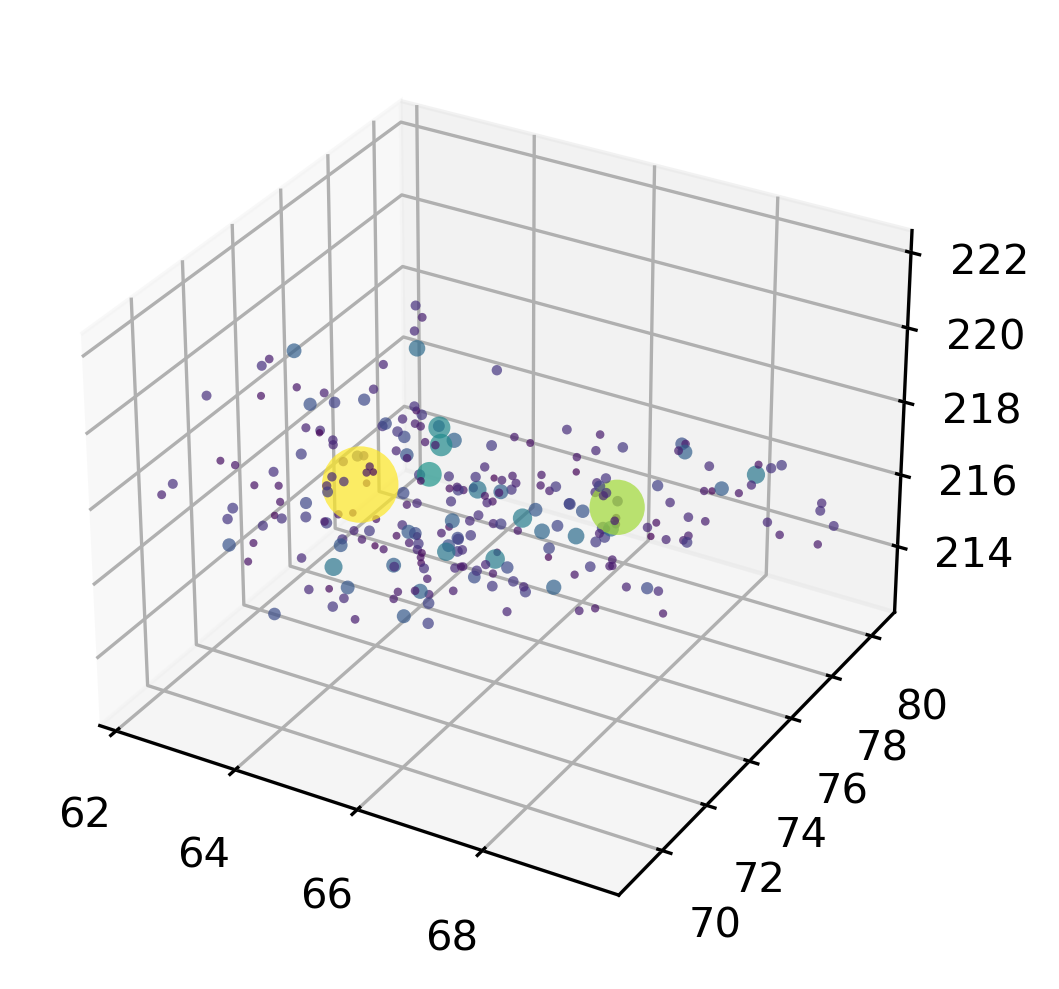

In [156]:
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(projection='3d')
ax.scatter(*b.positions.t(), c=b.x[:, 0], s=3**(b.x[:, 0] - 10), alpha=0.7, lw=0)

## Graph with edges

In [ ]:
data = Data(
    x=x,
    edge_index=torch.tensor(edge_index, dtype=torch.long),
    edge_attr=torch.tensor(edge_attr, dtype=torch.float),
    y=y,
    pos=pos,
    vel=vel,
    is_central=is_central,
    x_hydro=x_hydro,
    pos_hydro=pos_hydro,
    vel_hydro=vel_hydro,
    halfmassradius=halfmassradius
)
data

Data(x=[213011, 2], edge_index=[2, 1449199], edge_attr=[1449199, 6], y=[213011, 1], pos=[213011, 3], vel=[213011, 3], is_central=[213011, 1], x_hydro=[213011, 2], pos_hydro=[213011, 3], vel_hydro=[213011, 3], halfmassradius=[213011, 1])

In [47]:
dataloader = LinkNeighborLoader(
    data,
    num_neighbors=[30]*2,
    batch_size=256,
    edge_label_index=data.edge_index,
    edge_label=data.edge_attr
)

In [48]:
b = next(iter(dataloader))
b

Data(x=[170, 2], edge_index=[2, 778], edge_attr=[778, 6], y=[170, 1], pos=[170, 3], vel=[170, 3], is_central=[170, 1], x_hydro=[170, 2], pos_hydro=[170, 3], vel_hydro=[170, 3], halfmassradius=[170, 1], input_id=[256], edge_label_index=[2, 256], edge_label=[256, 6])

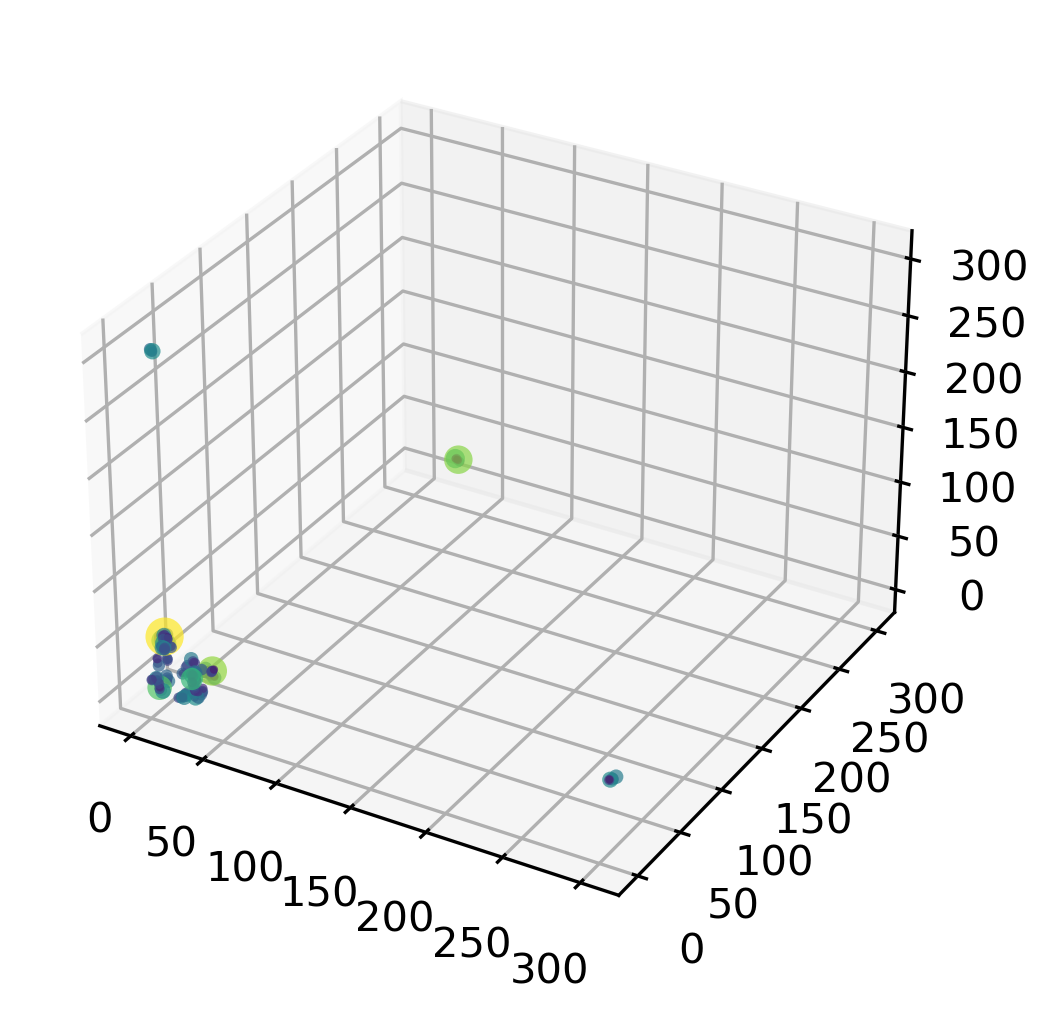

In [49]:
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(projection='3d')
ax.scatter(*b.pos.t(), c=b.x[:, 0], s=3**(b.x[:, 0] - 10), alpha=0.7, lw=0)

## Save Data object

In [50]:
# with open(f"{ROOT}/illustris_data/TNG300-1/PyG-Data_DMO-hydro.pkl", 'wb') as handle:
#     pickle.dump(data, handle)


# Train-test split

In [2]:
with open(f"{ROOT}/illustris_data/TNG300-1/PyG-Data_DMO-hydro.pkl", 'rb') as handle:
    data = pickle.load(handle)

In [3]:
# this is pytorch's weird way of doing np.argwhere()
train_indices = ((data.pos[:, 2] > 0) & (data.pos[:, 2] <= 200)).nonzero(as_tuple=True)[0]
val_indices = ((data.pos[:, 2] > 210) & (data.pos[:, 2] < 302.7)).nonzero(as_tuple=True)[0]

train_indices, val_indices

(tensor([   596,    597,    598,  ..., 213008, 213009, 213010]),
 tensor([     0,      1,      2,  ..., 212997, 212999, 213006]))

In [4]:
# ensure zero overlap
assert (set(train_indices) & set(val_indices)) == set()

In [12]:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [5]:
## very slow...

# train_sampler = SubsetRandomSampler(train_indices)
# val_sampler = SubsetRandomSampler(val_indices)

# train_loader = LinkNeighborLoader(
#     data,
#     num_neighbors=[30]*2,
#     batch_size=32,
#     edge_label_index=data.edge_index,
#     edge_label=data.edge_attr,
#     sampler=train_sampler
# )

# valid_loader = LinkNeighborLoader(
#     data,
#     num_neighbors=[30]*2,
#     batch_size=32,
#     edge_label_index=data.edge_index,
#     edge_label=data.edge_attr,
#     sampler=val_sampler
# )


In [6]:


# train_loader = NeighborLoader(
#     data,
#     num_neighbors=[30]*2,
#     batch_size=32,
#     sampler=train_sampler
# )

# valid_loader = NeighborLoader(
#     data,
#     num_neighbors=[30]*2,
#     batch_size=1024,
#     sampler=val_sampler
# )

In [7]:
# next(iter(valid_loader))

Data(x=[10517, 2], edge_index=[2, 86117], edge_attr=[86117, 6], y=[10517, 1], pos=[10517, 3], vel=[10517, 3], is_central=[10517, 1], x_hydro=[10517, 2], pos_hydro=[10517, 3], vel_hydro=[10517, 3], halfmassradius=[10517, 1], input_id=[1024], batch_size=1024)

# Train

In [5]:
# include edges as features as well...
data.x = torch.cat((data.x, data.is_central.type(torch.float)), dim=-1)

In [6]:
class EdgeInteractionLayer(MessagePassing):
    """Interaction network layer with node + edge layers.
    """
    def __init__(self, n_in, n_hidden, n_latent, aggr='sum'):
        super(EdgeInteractionLayer, self).__init__(aggr)

        self.mlp = nn.Sequential(
            nn.Linear(n_in, n_hidden, bias=True),
            nn.LayerNorm(n_hidden),
            nn.SiLU(),
            nn.Linear(n_hidden, n_hidden, bias=True),
            nn.LayerNorm(n_hidden),
            nn.SiLU(),
            nn.Linear(n_hidden, n_latent, bias=True),
        )

        self.messages = 0.
        self.input = 0.

    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):

        self.input = torch.cat([x_i, x_j, edge_attr[0]], dim=-1)
        self.messages = self.mlp(self.input)

        return self.messages

class EdgeInteractionGNN(nn.Module):
    """Graph net over nodes and edges with multiple unshared layers, and sequential layers with residual connections.
    Self-loops also get their own MLP (i.e. galaxy-halo connection).
    """
    def __init__(
        self, n_layers, D_link, node_features=2, edge_features=6, hidden_channels=64, aggr="sum", 
        latent_channels=64, n_out=2, n_unshared_layers=4, loop=True
    ):
        super(EdgeInteractionGNN, self).__init__()

        self.n_in = 2 * node_features + edge_features 
        self.n_out = n_out
        
        layers = [
            nn.ModuleList([
                EdgeInteractionLayer(self.n_in, hidden_channels, latent_channels, aggr=aggr)
                for _ in range(n_unshared_layers)
            ])
        ]
        for _ in range(n_layers-1):
            layers += [
                nn.ModuleList([
                    EdgeInteractionLayer(2 * 3 * latent_channels * n_unshared_layers + edge_features, hidden_channels, latent_channels, aggr=aggr) 
                    for _ in range(n_unshared_layers)
                ])
            ]
   
        self.layers = nn.ModuleList(layers)
        
        n_pool = (len(aggr) if isinstance(aggr, list) else 1) 
        self.fc = nn.Sequential(
            nn.Linear((n_unshared_layers * n_pool )* latent_channels, latent_channels, bias=True),
            nn.LayerNorm(latent_channels),
            nn.SiLU(),
            nn.Linear(latent_channels, latent_channels, bias=True),
            nn.LayerNorm(latent_channels),
            nn.SiLU(),
            nn.Linear(latent_channels, latent_channels, bias=True)
        )
        
        self.galaxy_halo_mlp = nn.Sequential(
            nn.Linear(latent_channels + node_features, latent_channels, bias=True),
            nn.LayerNorm(latent_channels),
            nn.SiLU(),
            nn.Linear(latent_channels, latent_channels, bias=True),
            nn.LayerNorm(latent_channels),
            nn.SiLU(),
            nn.Linear(latent_channels, 2 * n_out, bias=True)
        )
        
        self.D_link = D_link
        self.loop = loop
        self.pooled = 0.
        self.h = 0.

    def forward(self, data):
        
        # determine edges by getting neighbors within radius defined by `D_link`
        edge_index = radius_graph(data.pos, r=self.D_link, batch=data.batch, loop=self.loop)
        edge_attr = data.edge_attr[edge_index]

        # update hidden state on edge (h, or sometimes e_ij in the text)
        h = torch.cat([unshared_layer(data.x, edge_index=edge_index, edge_attr=edge_attr) for unshared_layer in self.layers[0]], axis=1)
        self.h = h
        h = h.relu()
        
        for layer in self.layers[1:]:
            # if multiple layers deep, also use a residual layer
            h = self.h + torch.cat([unshared_layer(h, edge_index=edge_index, edge_attr=edge_attr) for unshared_layer in layer], axis=1)
        
            self.h = h
            h = h.relu()
        
        x = torch.concat([self.fc(h), data.x], axis=1) # latent channels + data.x
                
        return (self.galaxy_halo_mlp(x))


In [14]:
node_features = data.x.shape[1]
edge_features = data.edge_attr.shape[1]
out_features = data.y.shape[1]

D_link = 2.5
use_loops = True
n_layers = 1
n_unshared_layers = 16
n_hidden_channels = 16
n_latent_channels = 16

aggr = "multi"

augment = True
n_epochs = 1000
lr = 1e-2
wd = 1e-4
betas_adam = (0.9, 0.95)

# min_batch_size = 64
batch_size = 8192

device = "cuda" if torch.cuda.is_available() else "cpu"


In [15]:
model = EdgeInteractionGNN(
    node_features=node_features,
    edge_features=edge_features, 
    n_layers=n_layers, 
    D_link=D_link,
    hidden_channels=n_hidden_channels,
    latent_channels=n_latent_channels,
    loop=use_loops,
    n_unshared_layers=n_unshared_layers,
    n_out=out_features,
    aggr=(["sum", "max", "mean"] if aggr == "multi" else aggr)
)

model.to(device);

In [16]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=lr, 
    weight_decay=wd,
    betas=betas_adam,
)


In [17]:

def train(dataloader, model, optimizer, device, augment=True):
    """Assumes that data object in dataloader has 8 columns: x,y,z, vx,vy,vz, Mh, Vmax"""
    model.train()

    loss_total = 0
    for data in (dataloader):
        if augment: # add random noise
            data_node_features_scatter = 4e-3 * torch.randn_like(data.x) * torch.std(data.x, dim=0)
            data_edge_features_scatter = 4e-3 * torch.randn_like(data.edge_attr) * torch.std(data.edge_attr, dim=0)
            
            data.x += data_node_features_scatter
            data.edge_attr += data_edge_features_scatter

        data.to(device)

        optimizer.zero_grad()
        y_pred, logvar_pred = model(data).chunk(2, dim=1)
        y_pred = y_pred.view(-1, model.n_out)
        logvar_pred = logvar_pred.view(-1, model.n_out)

        # compute loss as sum of two terms for likelihood-free inference
        loss_mse = F.mse_loss(y_pred, data.y)
        loss_lfi = F.mse_loss((y_pred - data.y)**2, 10**logvar_pred)

        loss = torch.log(loss_mse) + torch.log(loss_lfi)

        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    return loss_total / len(dataloader)

def validate(dataloader, model, device):
    model.eval()

    uncertainties = []
    loss_total = 0

    y_preds = []
    y_trues = []
    logvar_preds = []

    for data in (dataloader):
        with torch.no_grad():
            data.to(device)
            y_pred, logvar_pred = model(data).chunk(2, dim=1)
            y_pred = y_pred.view(-1, model.n_out)
            logvar_pred = logvar_pred.view(-1, model.n_out)
            uncertainties.append(np.sqrt(10**logvar_pred.detach().cpu().numpy()).mean(-1))

            # compute loss as sum of two terms a la Moment Networks (Jeffrey & Wandelt 2020)
            loss_mse = F.mse_loss(y_pred, data.y)
            loss_lfi = F.mse_loss((y_pred - data.y)**2, 10**logvar_pred)

            loss = torch.log(loss_mse) + torch.log(loss_lfi)

            loss_total += loss.item()
            y_preds += list(y_pred.detach().cpu().numpy())
            y_trues += list(data.y.detach().cpu().numpy())
            logvar_preds += list(logvar_pred.detach().cpu().numpy())

    y_preds = np.concatenate(y_preds)
    y_trues = np.array(y_trues)
    logvar_preds = np.concatenate(logvar_preds)
    uncertainties = np.concatenate(uncertainties)

    return (
        loss_total / len(dataloader),
        np.mean(uncertainties, -1),
        y_preds,
        y_trues,
        logvar_preds
    )
    

In [18]:
train_losses = []
valid_losses = []


valid_loader = RandomNodeLoader(
    data,
    num_parts=(len(val_indices) // batch_size),
    sampler=val_sampler
)

for epoch in range(n_epochs):
    # scheduled_batch_size = max(min_batch_size, int(np.round(batch_size * epoch / n_epochs)))

    train_loader = RandomNodeLoader(
        data,
        num_parts=len(train_indices) // batch_size,
        sampler=train_sampler
    )

    if epoch == int(n_epochs * 0.5):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=lr / 5, 
            weight_decay=wd,
            betas=betas_adam,
        )
    elif epoch == (n_epochs * 0.75):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=lr / 25, 
            weight_decay=wd,
            betas=betas_adam,
        )

    train_loss = train(train_loader, model, optimizer, device)
    valid_loss, valid_std, p, y, logvar_p  = validate(valid_loader, model, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f" {epoch + 1: >4d}    {train_loss: >7.3f}    {valid_loss: >7.3f}    {np.sqrt(np.mean((p - y.flatten())**2)): >7.4f}  {np.mean(valid_std): >7.4f}")


    1     13.165     12.021     8.4364   4.8929
    2      9.795      9.064     7.7956   8.2608
    3      8.598      8.399     7.2117   6.9803
    4      8.119      7.829     6.5188   6.4485
    5      7.547      7.102     5.7405   5.7524
    6      6.836      8.226     4.8136   5.9510
    7      7.135      6.352     4.2178   4.6938
    8      5.713      5.113     3.6295   3.4976
    9      4.484      3.374     2.7612   2.9159
   10      3.550      4.772     1.6177   3.0327
   11      1.961     -1.266     0.7503   0.9028
   12     -2.997     -4.601     0.4487   0.3632
   13     -5.565     -3.865     0.5038   0.2810
   14     -6.357     -5.576     0.3749   0.2435
   15     -6.809     -7.312     0.2671   0.2538
   16     -7.901     -7.403     0.2586   0.2033
   17     -8.371     -8.693     0.2030   0.2037
   18     -8.808     -8.894     0.1955   0.1936
   19     -8.903     -8.963     0.1937   0.1955
   20     -8.935     -8.859     0.1976   0.1890
   21     -8.704     -8.502     0.2138  

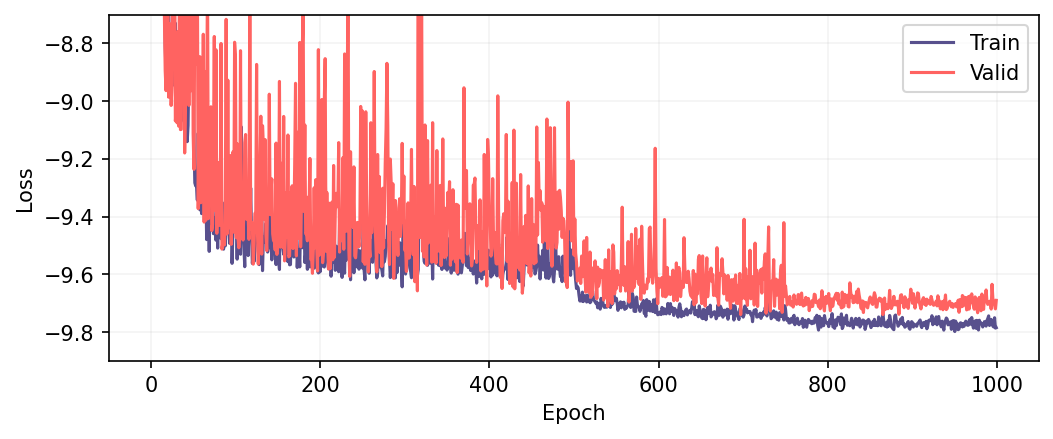

In [25]:
plt.figure(figsize=(8, 3), dpi=150)
plt.plot(train_losses, c=c1, label="Train")
plt.plot(valid_losses, c=c3, label='Valid')
plt.ylim(-9.9, -8.7)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.15)

In [20]:
torch.save(model.state_dict(), f"{ROOT}/results/dmo-hydro-model.pt")

In [21]:
_, _, preds, trues, logvar_preds = validate(valid_loader, model, device)

(9.0, 13.0)

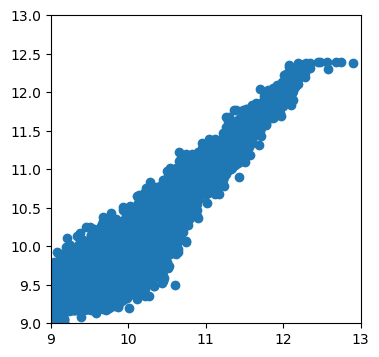

In [22]:
plt.figure(figsize=(4, 4))
plt.scatter(trues, preds)
plt.xlim(9, 13)
plt.ylim(9, 13)

# Compare against baseline model

In [14]:
Mstar = data.y[:, 0].numpy()
Mhalo = data.x[:, 0].numpy()
Vmax = data.x[:, 1].numpy()
is_central = data.is_central.numpy().flatten().astype(bool)

sham_central = np.vstack([list(reversed(sorted((Mhalo[is_central])))), list(reversed(sorted(Mstar[is_central])))])
sham_satellite = np.vstack([list(reversed(sorted((Mhalo[~is_central])))), list(reversed(sorted(Mstar[~is_central])))])


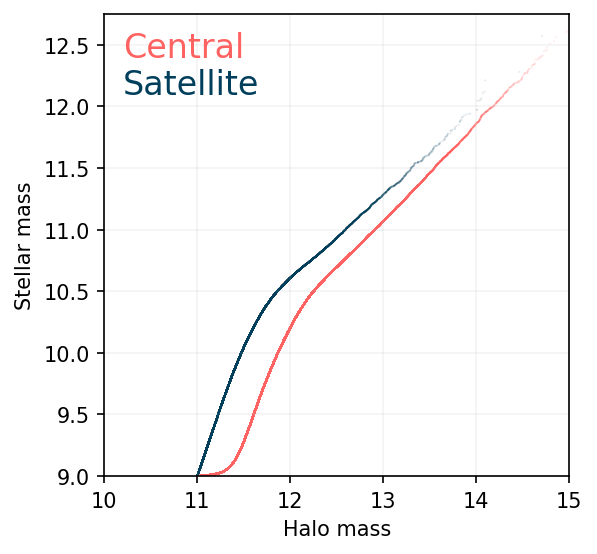

In [57]:
sc_kwargs = dict(s=1, edgecolor="none", alpha=0.1)

plt.figure(figsize=(4,4), dpi=150)

plt.scatter(*sham_central, c=c3, **sc_kwargs)
plt.scatter(*sham_satellite, c=c0, **sc_kwargs)
plt.xlim(10, 15)
plt.ylim(9, 12.75)
plt.text(10.2, 12.4, "Central", color=c3, fontsize=16)
plt.text(10.2, 12.1, "Satellite", color=c0, fontsize=16)
plt.xlabel("Halo mass")
plt.ylabel("Stellar mass")
plt.grid(alpha=0.15)



In [15]:
sham_vmax_central = np.vstack([list(reversed(sorted((Vmax[is_central])))), list(reversed(sorted(Mstar[is_central])))])
sham_vmax_satellite = np.vstack([list(reversed(sorted((Vmax[~is_central])))), list(reversed(sorted(Mstar[~is_central])))])

In [16]:
sham_vmax_central_interp = lambda V: np.interp(V, *sham_vmax_central.T[::-1].T)
sham_vmax_satellite_interp = lambda V: np.interp(V, *sham_vmax_satellite.T[::-1].T)

sham_vmax_predictions = lambda V, cen: np.where(cen, sham_vmax_central_interp(V), sham_vmax_satellite_interp(V))

In [17]:
Mstar_sham_vmax = [sham_vmax_predictions(V, cen) for V, cen in zip(Vmax, is_central)]

In [18]:
((Mstar_sham_vmax - Mstar)**2).mean()**0.5

0.17965554492771776

# Compare with hydro

In [44]:
data_hydro = data.clone()

x, pos, vel = data.x, data.pos, data.vel
x_hydro, pos_hydro, vel_hydro = data.x_hydro, data.pos_hydro, data.vel_hydro

data_hydro.x = torch.cat((x_hydro, data.is_central.type(torch.float)), dim=-1)
data_hydro.pos = pos_hydro
data_hydro.vel = vel_hydro

In [45]:
data_hydro.x

tensor([[15.2050,  1.2416,  1.0000],
        [14.6606,  1.1188,  0.0000],
        [13.0927,  0.7132,  0.0000],
        ...,
        [10.7299, -0.0207,  1.0000],
        [10.7742, -0.1035,  1.0000],
        [10.6089, -0.1268,  1.0000]])

In [68]:
node_features = data.x.shape[1]
edge_features = data.edge_attr.shape[1]
out_features = data.y.shape[1]

D_link = 2.5
use_loops = True
n_layers = 1
n_unshared_layers = 16
n_hidden_channels = 16
n_latent_channels = 16

aggr = "multi"

augment = True
n_epochs = 1000
lr = 1e-2
wd = 1e-4
betas_adam = (0.9, 0.95)

# min_batch_size = 64
batch_size = 8192

device = "cuda" if torch.cuda.is_available() else "cpu"


In [69]:
model = EdgeInteractionGNN(
    node_features=node_features,
    edge_features=edge_features, 
    n_layers=n_layers, 
    D_link=D_link,
    hidden_channels=n_hidden_channels,
    latent_channels=n_latent_channels,
    loop=use_loops,
    n_unshared_layers=n_unshared_layers,
    n_out=out_features,
    aggr=(["sum", "max", "mean"] if aggr == "multi" else aggr)
)

model.to(device);

In [70]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=lr, 
    weight_decay=wd,
    betas=betas_adam,
)

In [71]:
train_losses = []
valid_losses = []


valid_loader = RandomNodeLoader(
    data_hydro,
    num_parts=(len(val_indices) // batch_size),
    sampler=val_sampler
)

for epoch in range(n_epochs):
    # scheduled_batch_size = max(min_batch_size, int(np.round(batch_size * epoch / n_epochs)))

    train_loader = RandomNodeLoader(
        data_hydro,
        num_parts=len(train_indices) // batch_size,
        sampler=train_sampler
    )

    if epoch == int(n_epochs * 0.5):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=lr / 5, 
            weight_decay=wd,
            betas=betas_adam,
        )
    elif epoch == (n_epochs * 0.75):
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=lr / 25, 
            weight_decay=wd,
            betas=betas_adam,
        )

    train_loss = train(train_loader, model, optimizer, device)
    valid_loss, valid_std, p, y, logvar_p  = validate(valid_loader, model, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f" {epoch + 1: >4d}    {train_loss: >7.3f}    {valid_loss: >7.3f}    {np.sqrt(np.mean((p - y.flatten())**2)): >7.4f}  {np.mean(valid_std): >7.4f}")


    1     12.615     11.860     7.3091   1.6521
    2     10.401      8.710     5.9092   6.7833
    3      7.561      7.054     5.0485   4.7654
    4      6.485      5.835     3.9157   3.9971
    5      5.171      4.165     2.5961   2.6312
    6      2.691      0.115     0.9099   1.1680
    7     -2.379     -3.192     0.5126   0.2908
    8     -5.084     -0.934     0.8504   0.3072
    9      0.776     -3.529     0.5139   0.2748
   10     -4.541     -5.020     0.4078   0.4352
   11     -6.092     -5.639     0.3816   0.2582
   12     -4.381     -0.512     0.9062   0.2108
   13     -1.489     -0.257     0.9156   0.2156
   14     -3.536     -5.222     0.3989   0.3851
   15     -5.698     -8.332     0.2478   0.2832
   16     -8.332     -8.201     0.2279   0.1598
   17     -9.530    -10.224     0.1577   0.1602
   18    -10.158     -9.793     0.1700   0.1555
   19    -10.164     -9.742     0.1736   0.1598
   20    -10.171    -10.450     0.1522   0.1586
   21    -10.353     -9.915     0.1701  

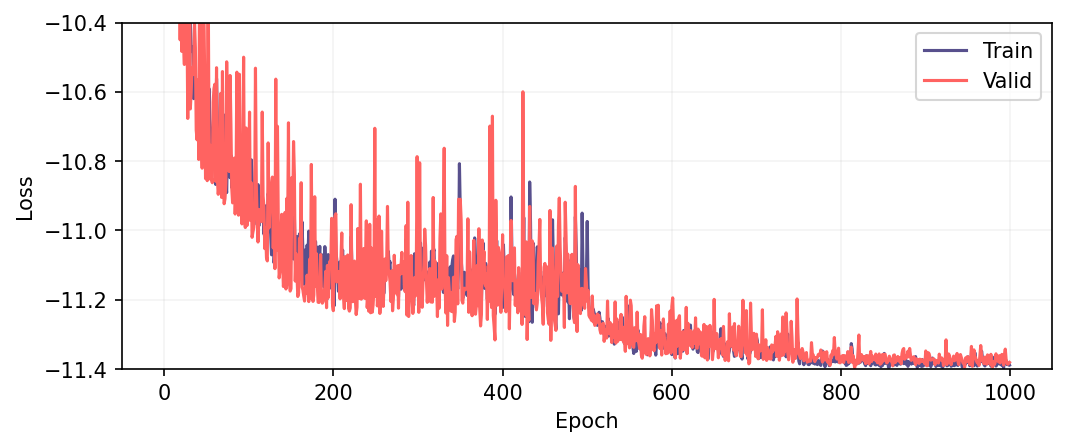

In [72]:
plt.figure(figsize=(8, 3), dpi=150)
plt.plot(train_losses, c=c1, label="Train")
plt.plot(valid_losses, c=c3, label='Valid')
plt.ylim(-11.4, -10.4)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.15)